# Purpose

Show that when you train models on bulk data with no composition variance you get a reduction in performance for tissue related GO Terms

In [10]:
import pandas as pd
import os 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


### Load GO learnability from Brain with no composition variance

In [20]:
# Load df for GO learnability from brain with MGES regressed
def load_regressed_performance(path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/deconvolutingBulk/data/dev/july_boot_29")->pd.DataFrame:
    """Loads performance from 62 simulations where composition variance from brain markers was regressed out

    Args:
        path (str, optional): path to regression performance directory

    Returns:
        pd.DataFrame: Dataframe that has performance for bulk brain with regressed comp
    """

    lo_dirs = os.listdir(path)
    lo_potential_files = [f"{path}/{dir}/melted_EGAD.csv" for dir in lo_dirs]

    def filter_existing_paths(paths):
        """Filter out paths that do not exist."""
        existing_paths = [path for path in paths if os.path.exists(path)]
        return existing_paths
    lo_files = filter_existing_paths(lo_potential_files)
    
    lo_dfs = [pd.read_csv(file, index_col=0) for file in lo_files]

    def add_boot_col(lo_dfs):
        lo_new_dfs = []
        for i,df in enumerate(lo_dfs):
            df['boot']=i
            lo_new_dfs.append(df)
        return lo_new_dfs
    lo_dfs = add_boot_col(lo_dfs=lo_dfs)
    
    df = pd.concat(lo_dfs, axis = 0)
    # df_grouped = df.reset_index().groupby(by = ['index', 'tissue', 'type'])['auc'].mean().reset_index()
    return df #df_grouped

GO_learnabilty_regressed = load_regressed_performance()
GO_learnabilty_regressed_mean = GO_learnabilty_regressed.loc[:,['auc','type']].reset_index().groupby(['index','type']).mean().reset_index() # aggragate over repeats
GO_learnabilty_regressed_mean.head()

,index,type,auc
0,GO:0000045,markers,0.535564
1,GO:0000045,random,0.547717
2,GO:0000070,markers,0.666578
3,GO:0000070,random,0.692279
4,GO:0000077,markers,0.566519


### Load GO Tissue Curations

In [12]:
def load_GO_curations(patho_to_curations="/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024_march/data/GOCurations.tsv"):
	GO_curations = pd.read_csv(patho_to_curations, sep = "\t")

	def melt_curations(df:pd.DataFrame)->pd.DataFrame:
		"""
		create a new column that is a melted version of the GO term curations

		Parameters:
		- df: pandas DataFrame

		Returns:
		- pandas DataFrame with a new column 'meta' indicating the curation category of the GO term
		"""
		# Create a new column using conditions
		meta = df.apply(lambda row: 'Brain' if row['BrainAffiliated'] == 'T' else ('PBMC' if row['PBMCAffiliated'] == 'T' else "Neither"), axis=1)
		df['meta']=meta
		
		return df
	GO_curations = melt_curations(GO_curations)
	return GO_curations

GO_curations = load_GO_curations()
GO_curations.head()

,id,name,namespace,CTAffiliated,BrainAffiliated,PBMCAffiliated,def,meta
0,GO:0000045,autophagosome assembly,biological_process,F,F,F,The formation of a double membrane-bounded str...,Neither
1,GO:0000070,mitotic sister chromatid segregation,biological_process,F,F,F,The cell cycle process in which replicated hom...,Neither
2,GO:0000077,DNA damage checkpoint signaling,biological_process,F,F,F,A signal transduction process that contributes...,Neither
3,GO:0000079,regulation of cyclin-dependent protein serine/...,biological_process,F,F,F,"Any process that modulates the frequency, rate...",Neither
4,GO:0000082,G1/S transition of mitotic cell cycle,biological_process,F,F,F,The mitotic cell cycle transition by which a c...,Neither


In [21]:
def process_dfs(GO_curations, GO_learnabilty_regressed):
	GO_learnabilty_regressed = GO_learnabilty_regressed.rename(columns={'auc':'reg_auc'})

	GO_curations = GO_curations.loc[:,['id','meta']]

	merged = pd.merge(GO_learnabilty_regressed, GO_curations, left_on='index', right_on='id')
	merged = merged.drop(columns = 'index')
	return merged	
merged = process_dfs(GO_curations, GO_learnabilty_regressed_mean)
merged.head()
	

,type,reg_auc,id,meta
0,markers,0.535564,GO:0000045,Neither
1,random,0.547717,GO:0000045,Neither
2,markers,0.666578,GO:0000070,Neither
3,random,0.692279,GO:0000070,Neither
4,markers,0.566519,GO:0000077,Neither


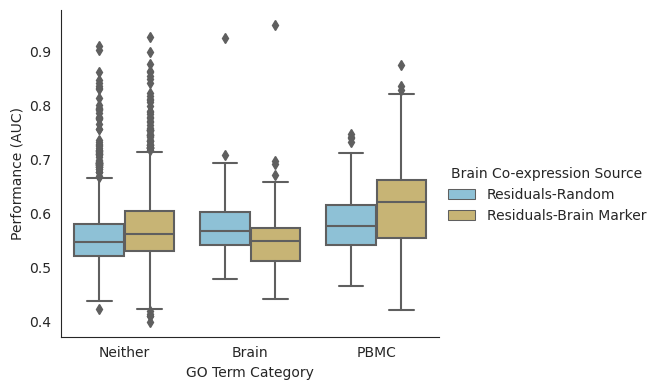

In [22]:
def plot_regressed_comparison(merged):
    sns.set_style('white')
    palette = sns.color_palette('muted')[::-1]
    legend_name = "Brain Co-expression Source"
    merged = merged.rename(columns={'type':legend_name})
    # Mapping dictionary
    mapping = {
        # "auc_bulk": "Bulk",
        "markers": "Residuals-Brain Marker",
        "random": "Residuals-Random"
    }
    # Replace values in the column
    merged.loc[:,legend_name] = merged.loc[:,legend_name].replace(mapping)

    merged[legend_name] = pd.Categorical(merged[legend_name], ordered=True, categories=[ "Residuals-Random", "Residuals-Brain Marker"]) # categories=["Bulk", "Residuals-Random", "Residuals-Brain Marker"]
    # # Using sns.catplot for facetting
    g = sns.catplot(data=merged, x = 'meta', y='reg_auc', hue=f"{legend_name}", kind='box', height=4, aspect=1.2, palette=palette)
    g.set_axis_labels(x_var="GO Term Category", y_var = "Performance (AUC)")
    
    plt.savefig('figs/comp_effect_removed.png', dpi = 300, bbox_inches='tight')
    plt.show()

plot_regressed_comparison(merged)

In [38]:
def fit_mixed_model_no_compv(GO_learnabilty_regressed, GO_curations):

    GO_learnabilty_regressed = GO_learnabilty_regressed.loc[:,['auc','type','boot']]
    GO_curations = GO_curations.loc[:,['id','meta']]
    merged = pd.merge(GO_learnabilty_regressed,GO_curations, left_index=True, right_on="id")

    # Defining the levels for categorical variables
    merged['meta'] = pd.Categorical(merged.loc[:,'meta'], categories = ["Neither", "Brain", "PBMC"], ordered=True)
    merged['coexpression'] = pd.Categorical(merged.loc[:,'type'], categories = ['random', 'markers'], ordered=True)
    
    # Creating the formula for the mixed-effects model
    formula = 'auc ~  meta * coexpression'
    
    # Fitting the mixed-effects model using smf.mixedlm
    # 'index' is specified as the grouping variable for random effects
    model = smf.mixedlm(formula, data=merged, groups = merged['id'], re_formula='~coexpression')
    mixed_model_fit = model.fit()

    return mixed_model_fit


compV_removed_model = fit_mixed_model_no_compv(GO_learnabilty_regressed, GO_curations)
compV_removed_model.summary()

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:                    MixedLM         Dependent Variable:         auc        
No. Observations:         379712          Method:                     REML       
No. Groups:               1396            Scale:                      0.0014     
Min. group size:          272             Log-Likelihood:             699232.0005
Max. group size:          272             Converged:                  Yes        
Mean group size:          272.0                                                  
---------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              0.558    0.002 312.207 0.000  0.555  0.562
meta[T.Brain]                          0.018    0.006   2.815 0.005  0.005  0.030
meta[T.PBMC]                           0.024    0.006   4.222 0.000  0.013  0.035
coexpression[T.markers]                0.016    0.002  10.318 0.000  0.013  0.020
meta[T.Brain]:coexpression[T.markers] -0.039    0.006  -6.948 0.000 -0.050 -0.028
meta[T.PBMC]:coexpression[T.markers]   0.020    0.005   3.922 0.000  0.010  0.030
Group Var                              0.004    0.004                            
Group x coexpression[T.markers] Cov   -0.001    0.002                            
coexpression[T.markers] Var            0.003    0.003                            
=================================================================================

"""